## Setup

Load libraries:

In [2]:
import srtm
import torch
import pickle
import rioxarray
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from snowmodels.density import SturmDensity, JonasDensity, PistochiDensity 
from snowmodels.utils import ConvertData, plot_learning_curve, compare_multiple_models

## Load Data

* Maine Snow Survey Data: Click [here](https://mgs-maine.opendata.arcgis.com/datasets/maine-snow-survey-data/explore)

In [3]:
maine_data=pd.read_csv('../data/Maine_Snow_Survey_Data.csv', low_memory=False)
maine_data.info()
maine_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48292 entries, 0 to 48291
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   X                 48292 non-null  float64
 1   Y                 48292 non-null  float64
 2   OBJECTID          48292 non-null  int64  
 3   SITE_ID           48292 non-null  int64  
 4   SITE_NAME         48292 non-null  object 
 5   MOVED_TO_SITE_ID  1684 non-null   float64
 6   SURVEY            29480 non-null  float64
 7   SURVEY_YEAR       48292 non-null  int64  
 8   SURVEY_DATE       46998 non-null  object 
 9   SURVEY_DATE_TEXT  48292 non-null  object 
 10  DEPTH             48292 non-null  float64
 11  WATER             48288 non-null  float64
 12  DENSITY           48288 non-null  float64
 13  CONFIDENCE_LEVEL  48292 non-null  object 
 14  SOURCE            48292 non-null  object 
 15  COMMENT           31309 non-null  object 
 16  ERROR             1900 non-null   object

,X,Y,OBJECTID,SITE_ID,SITE_NAME,MOVED_TO_SITE_ID,SURVEY,SURVEY_YEAR,SURVEY_DATE,SURVEY_DATE_TEXT,...,WATER,DENSITY,CONFIDENCE_LEVEL,SOURCE,COMMENT,ERROR,TRACE,LATITUDE,LONGITUDE,MGS_Key
0,689248.0000,4.758152e+06,1,1029,DIAMONDS (UWP),NaN,NaN,1903,1903/03/15 05:00:00+00,03/15/1903,...,7.80,0.24,UNKNOWN,NONE,,DATA FOR UNLOCATED SITE,NaN,42.952513,-66.680008,1
1,342400.8963,4.978854e+06,2,1028,AZISCOHOS/AZISCOHOS DAM (UWP),NaN,NaN,1906,1906/04/01 05:00:00+00,04/01/1906,...,2.40,0.34,UNKNOWN,NONE,,NaN,NaN,44.945659,-70.997712,2
2,331387.7661,4.961476e+06,3,1027,ERROL/ERROL DAM (UWP),NaN,NaN,1911,1911/03/01 05:00:00+00,03/01/1911,...,6.90,0.23,UNKNOWN,NONE,,NaN,NaN,44.786800,-71.131440,3
3,689248.0000,4.758152e+06,4,1139,RUMFORD (UWP),NaN,NaN,1911,1911/03/04 05:00:00+00,03/04/1911,...,3.75,0.47,UNKNOWN,NONE,,DATA FOR UNLOCATED SITE,NaN,42.952513,-66.680008,4
4,342400.8963,4.978854e+06,5,1028,AZISCOHOS/AZISCOHOS DAM (UWP),NaN,NaN,1911,1911/03/07 05:00:00+00,03/07/1911,...,6.50,0.24,UNKNOWN,NONE,,NaN,NaN,44.945659,-70.997712,5


* Snow Classification Dataset ([Matthew Sturm and Glen E. Liston](https://journals.ametsoc.org/view/journals/hydr/22/11/JHM-D-21-0070.1.xml)): You can download the data on [NSIDC](https://nsidc.org/data/nsidc-0768/versions/1). Please download `SnowClass_NA_300m_10.0arcsec_2021_v01.0.nc`.

In [5]:
snow_class_raster=rioxarray.open_rasterio('../data/SnowClass_NA_300m_10.0arcsec_2021_v01.0.nc')

## Data Preparation

In [6]:
# initialize the elevation class
elevation_data = srtm.get_data()
confidence_level = ["GOOD"] # options: UNKNOWN, GOOD, QUESTIONABLE, DUMMY SITE
clean_df=(
    maine_data
    .query('CONFIDENCE_LEVEL in @confidence_level and DENSITY > 0 and DENSITY < 1')
    .filter(items=['SURVEY_DATE_TEXT' ,'DENSITY', 'WATER', 'DEPTH', 'LATITUDE', 'LONGITUDE', 'SITE_NAME'])
    .assign(
        Date=lambda x: pd.to_datetime(x.SURVEY_DATE_TEXT),
        Snow_Class=lambda x: x.loc[:, ["LONGITUDE", "LATITUDE"]].apply(lambda y: ConvertData.get_snow_class(lon=y.LONGITUDE, lat=y.LATITUDE, raster=snow_class_raster).capitalize(), axis=1),
        SWE=lambda x: ConvertData.inches_to_metric(inches=x.WATER, unit="cm"),
        Snow_Depth=lambda x: ConvertData.inches_to_metric(inches=x.DEPTH, unit="cm"),
        Snow_Density=lambda x: x.SWE / x.Snow_Depth,
        Sturm_DOWY=lambda x: x.Date.map(lambda y: ConvertData().date_to_DOY(y, algorithm="Sturm", origin=10)),
        Pistochi_DOWY=lambda x: x.Date.map(lambda y: ConvertData().date_to_DOY(y, algorithm="default", origin=11)),
        DOWY=lambda x: x.Date.map(lambda y: ConvertData().date_to_DOY(y, algorithm="default", origin=10)),
        Elevation= lambda x: x.loc[:, ["LONGITUDE", "LATITUDE"]].apply(lambda y: elevation_data.get_elevation(latitude=y.LATITUDE, longitude=y.LONGITUDE), axis=1)
    )
    .query(
        'Snow_Class != "Ocean"'
        " and Snow_Depth != 0 and SWE != 0 and "
        "Snow_Depth > 5 and SWE > 3 and "
        "Snow_Density <= 0.6 and Snow_Density >= 0.05"  # uncomment these queries to match the training scenario
    )
    .dropna()
    .rename(columns={
        'LATITUDE': 'Latitude',
        'LONGITUDE': 'Longitude'
    })
    .reset_index(drop=True)
    .drop(
        columns=[
            "SURVEY_DATE_TEXT",
            "WATER",
            "DEPTH",
            "DENSITY"
        ]
    )
)
clean_df.info()
clean_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21547 entries, 0 to 21546
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Latitude       21547 non-null  float64       
 1   Longitude      21547 non-null  float64       
 2   SITE_NAME      21547 non-null  object        
 3   Date           21547 non-null  datetime64[ns]
 4   Snow_Class     21547 non-null  object        
 5   SWE            21547 non-null  float64       
 6   Snow_Depth     21547 non-null  float64       
 7   Snow_Density   21547 non-null  float64       
 8   Sturm_DOWY     21547 non-null  float64       
 9   Pistochi_DOWY  21547 non-null  int64         
 10  DOWY           21547 non-null  int64         
 11  Elevation      21547 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(2), object(2)
memory usage: 2.0+ MB


,Latitude,Longitude,SITE_NAME,Date,Snow_Class,SWE,Snow_Depth,Snow_Density,Sturm_DOWY,Pistochi_DOWY,DOWY,Elevation
0,44.273728,-69.695069,AUGUSTA,1969-03-26,Alpine,18.288,58.42,0.313043,85.0,146,177,56.0
1,43.900019,-70.325791,GRAY (SAPPI),1969-03-26,Alpine,15.494,38.10,0.406667,85.0,146,177,94.0
2,43.416830,-70.661217,WEST KENNEBUNK,1969-03-26,Ephemeral,14.224,38.10,0.373333,85.0,146,177,74.0
3,44.002648,-69.947373,TOPSHAM,1969-03-26,Alpine,19.558,55.88,0.350000,85.0,146,177,69.0
4,43.734430,-70.257370,FALMOUTH,1969-03-26,Ephemeral,15.240,35.56,0.428571,85.0,146,177,49.0


In [7]:
clean_df.Snow_Density.describe(percentiles=[.1, .25, .5, .75, .90])

count    21547.000000
mean         0.279717
std          0.070297
min          0.073034
10%          0.193939
25%          0.230293
50%          0.274510
75%          0.323810
90%          0.371429
max          0.600000
Name: Snow_Density, dtype: float64

In [8]:
0.371429 - 0.193939

0.17749

In [9]:
with open('../data/data_splits.pkl', 'rb') as f:
    data_splits = pickle.load(f)

In [10]:
4.343750e-01 - 2.000000e-01

0.234375

In [11]:
data_splits.y_temp.describe(percentiles=[.1, .25, .5, .75, .90])

count    2.187744e+06
mean     3.027828e-01
std      9.242709e-02
min      5.000000e-02
10%      2.000000e-01
25%      2.333333e-01
50%      2.864198e-01
75%      3.625000e-01
90%      4.343750e-01
max      6.000000e-01
Name: Snow_Density, dtype: float64

In [12]:
clean_df.SITE_NAME.value_counts()

SITE_NAME
ALLAGASH                     279
KINGFIELD                    258
NEWRY (SCREW AUGER FALLS)    258
WINTERVILLE                  249
DYER BROOK                   249
                            ... 
SITE 1616                      1
SITE 1612                      1
SITE 1613                      1
SITE 1614                      1
SITE 1615                      1
Name: count, Length: 344, dtype: int64

* Train LGBM

In [14]:
import lightgbm as lgb
import yaml
from sklearn.preprocessing import  TargetEncoder
from snowmodels.utils import compare_multiple_models, ecnoder_preprocessor, load_data, model_variant_selector, load_config

In [15]:
raw_data=load_data('../data/data_splits.pkl', final_eval=True)
all_config = load_config(config_path='../experiments/hyperparameters.yaml')


snow_class_encoder = TargetEncoder(
        target_type = 'continuous', cv=5,
        random_state = all_config.global_cfg.seed, smooth = 'auto'
    )

In [16]:
x_cat_train = snow_class_encoder.fit_transform(raw_data.x_train.Snow_Class.to_frame(), raw_data.y_train)
x_cat_test = snow_class_encoder.transform(raw_data.x_val.Snow_Class.to_frame())
x_cat_test_maine = snow_class_encoder.transform(clean_df.Snow_Class.to_frame())

MAIN_FEATURES = [
    'Elevation', 'Snow_Depth', 'DOWY',
    'Latitude', 'Longitude'
]
CLIMATE_7_FEATURES = ['PRECIPITATION_lag_7d', 'TAVG_lag_7d']
CLIMATE_14_FEATURES = ['PRECIPITATION_lag_14d', 'TAVG_lag_14d']
NOMINAL_FEATURE = ['Snow_Class']
selected_features = MAIN_FEATURES + NOMINAL_FEATURE

x_train_prep = pd.concat(
    [raw_data.x_train.drop('Snow_Class', axis=1), x_cat_train],
    axis=1
)
x_train_main = x_train_prep.filter(items=selected_features)

x_test_prep = pd.concat(
    [raw_data.x_val.drop('Snow_Class', axis=1), x_cat_test],
    axis=1
)
x_test_main = x_test_prep.filter(items=selected_features)

x_test_prep_maine = pd.concat(
    [clean_df.drop('Snow_Class', axis=1), x_cat_test_maine],
    axis=1
)

x_test_maine = x_test_prep_maine.filter(items=selected_features)

In [17]:
with open('../experiments/results/tune_new/lightgbm_main_tune_target_20250902_200431.yaml', mode='r', encoding="utf-8") as file:
            raw_config = yaml.safe_load(file)

default_params= {
    'objective': 'regression',
    'metric': 'rmse',
    'random_state': all_config.global_cfg.seed,
    "force_col_wise": True,
    "verbosity": all_config.global_cfg.verbosity,
    "deterministic": True
}

params_from_optuna = raw_config['performance']['hyperparameters']
params_from_optuna.update(default_params)

train_data = lgb.Dataset(x_train_main, label=raw_data.y_train)

lgbm_main = lgb.train(
    params_from_optuna,
    train_data,
    num_boost_round=raw_config['performance']['metrics']['best_iteration'] # best iteration from Optuna
)

## Load ML Model and Encoder for Snow Class

In [18]:
# with open('../ML_weights/encoder.pkl', 'rb') as f:
#     loaded_encoder = pickle.load(f)

# # Use the loaded encoder
# new_X_cat = loaded_encoder.transform(clean_df['Snow_Class'])
# X_test_main = pd.concat([clean_df[['Elevation', 'Snow_Depth', 'DOWY']], new_X_cat], axis=1)

In [19]:
# xgb_main = xgb.Booster()
# xgb_main.load_model("../ML_weights/main_density_model.ubj")  # Load model from Uiversal Binary JSON file
# xgb_main.set_param({"device": "cuda:1"})

## Estimate Density

In [21]:
density_results=(
    clean_df
    .assign(
        Observed_Density=clean_df.Snow_Density,
        Jonas_Density=lambda x: x.loc[:, ('Snow_Depth', 'Date', 'Elevation')].apply(lambda y: JonasDensity().compute_density(snow_depth=y.Snow_Depth*0.01, month=y.Date.month_name(), elevation= y.Elevation), axis=1),
        Pistochi_Density=lambda x: x.loc[:, 'Pistochi_DOWY'].apply(lambda y: PistochiDensity().compute_density(DOY=y)),
        Sturm_Density=lambda x: x.loc[:, ('Snow_Depth', 'Sturm_DOWY', 'Snow_Class')].apply(lambda y: SturmDensity().compute_density(snow_depth=y.Snow_Depth, DOY=y.Sturm_DOWY, snow_class= y.Snow_Class), axis=1),
        LightGBM_Density=lgbm_main.predict(x_test_maine),
        Baseline_Density = clean_df.Snow_Density.mean()
    )
    .filter(items=['Observed_Density', 'Jonas_Density', 'Pistochi_Density', 'Sturm_Density', 'LightGBM_Density', 'SWE', 'Snow_Depth', 'Baseline_Density', 'Snow_Class'])
    .reset_index(drop=True)
)

density_results.head()

,Observed_Density,Jonas_Density,Pistochi_Density,Sturm_Density,LightGBM_Density,SWE,Snow_Depth,Baseline_Density,Snow_Class
0,0.313043,0.334753,0.407,0.345200,0.281326,18.288,58.42,0.279717,Alpine
1,0.406667,0.334143,0.407,0.338973,0.325259,15.494,38.10,0.279717,Alpine
2,0.373333,0.334143,0.407,NaN,0.363890,14.224,38.10,0.279717,Ephemeral
3,0.350000,0.334676,0.407,0.344430,0.285011,19.558,55.88,0.279717,Alpine
4,0.428571,0.334067,0.407,NaN,0.364808,15.240,35.56,0.279717,Ephemeral


## Compute SWE

In [22]:
swe_results=(
    density_results
    .assign(
        Observed_SWE=density_results.SWE.values,
        Jonas_SWE=lambda x: x.Jonas_Density.values * x.Snow_Depth.values,
        Sturm_SWE=lambda x: x.Sturm_Density.values * x.Snow_Depth.values,
        Pistochi_SWE=lambda x: x.Pistochi_Density.values * x.Snow_Depth.values,
        LightGBM_SWE=lambda x: x.LightGBM_Density.values * x.Snow_Depth.values,
        Baseline_SWE = lambda x: x.Baseline_Density.values * x.Snow_Depth.values
    )
    .drop(
        columns=[
            'Observed_Density', 
            'Jonas_Density', 
            'Pistochi_Density', 
            'Sturm_Density', 
            'Snow_Depth',
            'LightGBM_Density',
            'Baseline_Density',
            'SWE'
        ]
    )
)

swe_results.head()

,Snow_Class,Observed_SWE,Jonas_SWE,Sturm_SWE,Pistochi_SWE,LightGBM_SWE,Baseline_SWE
0,Alpine,18.288,19.556247,20.166613,23.77694,16.435055,16.341068
1,Alpine,15.494,12.730848,12.914864,15.50670,12.392370,10.657218
2,Ephemeral,14.224,12.730848,NaN,15.50670,13.864213,10.657218
3,Alpine,19.558,18.701717,19.246766,22.74316,15.926410,15.630587
4,Ephemeral,15.240,11.879415,NaN,14.47292,12.972573,9.946737


* Density Comparison

In [37]:
compare_multiple_models(preds_df=density_results.dropna().drop(columns=['Snow_Class', 'SWE', 'Snow_Depth']), y_true='Observed_Density')

,Jonas_Density,Pistochi_Density,Sturm_Density,LightGBM_Density
RMSE,0.075765,0.126228,0.078822,0.057063
MBE,0.040551,0.110304,0.044515,-0.005895
RSQ,-0.172746,-2.255197,-0.269308,0.334756


* SWE Comparison

In [38]:
compare_multiple_models(preds_df=swe_results.dropna().drop(columns='Snow_Class'), y_true='Observed_SWE')

,Jonas_SWE,Sturm_SWE,Pistochi_SWE,LightGBM_SWE
RMSE,4.702719,5.006462,7.805394,2.786057
MBE,2.742657,3.030645,6.171522,-0.319065
RSQ,0.497797,0.430829,-0.383473,0.823737


* Model Performance Comparison

In [13]:
compare_multiple_models(preds_df=swe_results.dropna().drop(columns='Snow_Class'), y_true='Observed_SWE')

,Jonas_SWE,Sturm_SWE,Pistochi_SWE,XGBoost_SWE
RMSE,4.497935,4.790041,7.432656,3.381312
MBE,2.492483,2.750972,5.617364,0.133310
RSQ,0.624994,0.574705,-0.024000,0.788075


## Retraining and Learning Curve

In [40]:
clean_df

,Latitude,Longitude,SITE_NAME,Date,Snow_Class,SWE,Snow_Depth,Snow_Density,Sturm_DOWY,Pistochi_DOWY,DOWY,Elevation
0,44.273728,-69.695069,AUGUSTA,1969-03-26,Alpine,18.2880,58.4200,0.313043,85.0,146,177,56.0
1,43.900019,-70.325791,GRAY (SAPPI),1969-03-26,Alpine,15.4940,38.1000,0.406667,85.0,146,177,94.0
2,43.416830,-70.661217,WEST KENNEBUNK,1969-03-26,Ephemeral,14.2240,38.1000,0.373333,85.0,146,177,74.0
3,44.002648,-69.947373,TOPSHAM,1969-03-26,Alpine,19.5580,55.8800,0.350000,85.0,146,177,69.0
4,43.734430,-70.257370,FALMOUTH,1969-03-26,Ephemeral,15.2400,35.5600,0.428571,85.0,146,177,49.0
...,...,...,...,...,...,...,...,...,...,...,...,...
21542,45.333046,-69.544027,MONSON,2024-04-16,Alpine,5.0546,10.2108,0.495025,107.0,168,199,381.0
21543,45.189181,-71.188302,MOOSE FALLS (NWS),2024-04-16,Alpine,11.6840,26.6700,0.438095,107.0,168,199,594.0
21544,47.150013,-66.879997,SERPENTINE LAKE (N.B.),2024-04-15,Alpine,6.0960,14.9860,0.406780,106.0,167,198,429.0
21545,47.030009,-66.980003,TROUSERS LAKE (N.B.),2024-04-15,Alpine,10.6680,28.1940,0.378378,106.0,167,198,402.0


/home/habeeb/miniconda3/envs/ml_density_env/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/home/habeeb/miniconda3/envs/ml_density_env/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


Text(0.5, 1.0, 'Data Efficiency for Model Transfer')

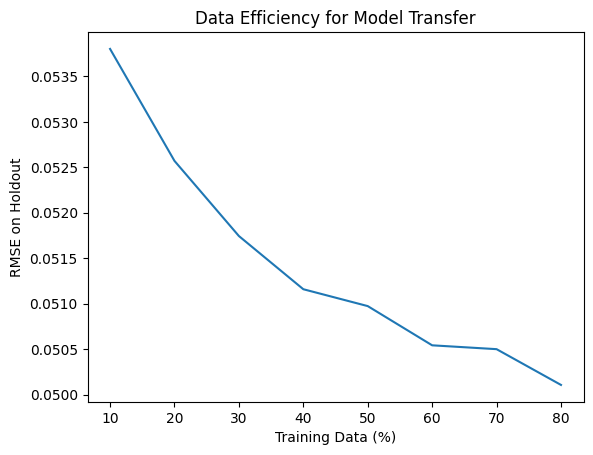

In [61]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error

# 1. Split your local data: 80% for retraining experiments, 20% holdout
X_retrain, X_test, y_retrain, y_test = train_test_split(
    x_test_maine, clean_df.Snow_Density, 
    test_size=0.2, random_state=all_config.global_cfg.seed, shuffle=True
)

# 2. Create 8 portions for 10%, 20%, ..., 80% experiments
retrain_portions_X = np.array_split(X_retrain, 8)
retrain_portions_y = np.array_split(y_retrain, 8)

# 3. Run experiments with increasing data
results = []
for i in range(1, 9):  # 1 to 8 portions
    # Combine first i portions
    X_train_subset = np.vstack(retrain_portions_X[:i])
    y_train_subset = np.concatenate(retrain_portions_y[:i])
    
    # Retrain model
    train_data = lgb.Dataset(X_train_subset, label=y_train_subset)
    
    retrained_model = lgb.train(
        params_from_optuna,
        train_data,
        num_boost_round=raw_config['performance']['metrics']['best_iteration']
    )
    
    # Test on holdout
    y_pred = retrained_model.predict(X_test)
    rmse = root_mean_squared_error(y_true=y_test, y_pred=y_pred)
    
    results.append({
        'training_size': len(y_train_subset),
        'training_percent': i * 10,
        'rmse': rmse
    })

# 4. Plot learning curve
plt.plot([r['training_percent'] for r in results], [r['rmse'] for r in results])
plt.xlabel('Training Data (%)')
plt.ylabel('RMSE on Holdout')
plt.title('Data Efficiency for Model Transfer')

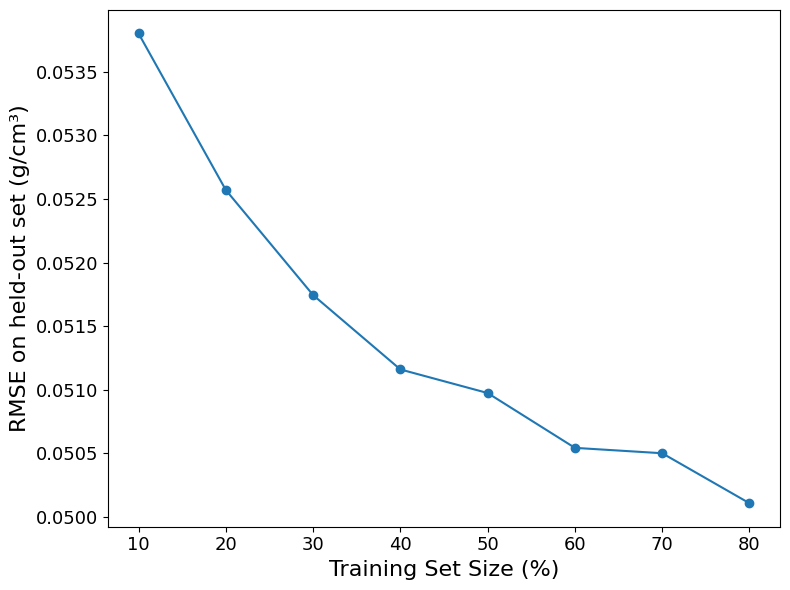

In [69]:
plt.figure(figsize=(8, 6))
plt.plot([r['training_percent'] for r in results], [r['rmse'] for r in results], 'o-')
plt.xlabel('Training Set Size (%)', fontsize=16)
plt.ylabel('RMSE on held-out set (g/cm³)', fontsize=16)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.tight_layout()
plt.savefig('../plots/figure11.jpg', dpi=300, bbox_inches='tight')
plt.show()

Test set: 69 stations, 4526 data points
Training iteration 1: 35 stations, 2007 data points
Training iteration 2: 70 stations, 3734 data points
Training iteration 3: 105 stations, 6010 data points
Training iteration 4: 139 stations, 8243 data points
Training iteration 5: 173 stations, 10479 data points
Training iteration 6: 207 stations, 12118 data points
Training iteration 7: 241 stations, 14296 data points
Training iteration 8: 275 stations, 17021 data points

Results Summary:
10%: 35 stations, 2007 samples, RMSE: 0.0568
20%: 70 stations, 3734 samples, RMSE: 0.0541
30%: 105 stations, 6010 samples, RMSE: 0.0535
40%: 139 stations, 8243 samples, RMSE: 0.0531
50%: 173 stations, 10479 samples, RMSE: 0.0522
60%: 207 stations, 12118 samples, RMSE: 0.0521
70%: 241 stations, 14296 samples, RMSE: 0.0519
80%: 275 stations, 17021 samples, RMSE: 0.0517


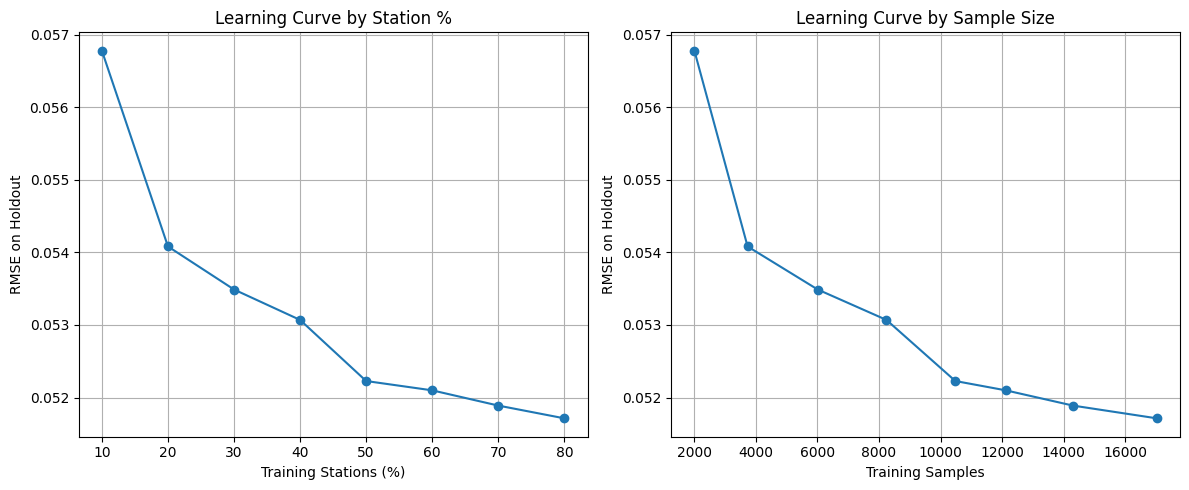

In [86]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import TargetEncoder

# Get unique stations
unique_stations = clean_df['SITE_NAME'].unique()

# 1. Split stations: 80% for retraining experiments, 20% holdout
retrain_stations, test_stations = train_test_split(
    unique_stations, 
    test_size=0.2, 
    random_state= 42,#all_config.global_cfg.seed, 100, 1000
    shuffle=True
)

# Get data for each set of stations
retrain_data = clean_df[clean_df['SITE_NAME'].isin(retrain_stations)]
test_data = clean_df[clean_df['SITE_NAME'].isin(test_stations)]

# Prepare test set (we'll use same test set for all experiments)
feature_cols = ['Elevation', 'Snow_Depth', 'DOWY', 'Latitude', 'Longitude', 'Snow_Class']
X_test = test_data[feature_cols].copy()
y_test = test_data['Snow_Density']

print(f"Test set: {len(test_stations)} stations, {len(y_test)} data points")

# 2. Create 8 portions of retrain stations for 10%, 20%, ..., 80% experiments
retrain_station_portions = np.array_split(retrain_stations, 8)

# 3. Run experiments with increasing stations
results = []
for i in range(1, 9):  # 1 to 8 portions
    # Get stations for this experiment (first i portions)
    stations_subset = np.concatenate(retrain_station_portions[:i])
    
    # Get data for these stations
    train_subset = clean_df[clean_df['SITE_NAME'].isin(stations_subset)]
    
    # Prepare features and target
    X_train_subset = train_subset[feature_cols].copy()
    y_train_subset = train_subset['Snow_Density']
    
    print(f"Training iteration {i}: {len(stations_subset)} stations, {len(y_train_subset)} data points")
    
    # Encode Snow_Class for training data
    snow_class_encoder = TargetEncoder(
        target_type = 'continuous', cv=5,
        random_state = all_config.global_cfg.seed, smooth = 'auto'
    )
    
    X_train_subset['Snow_Class'] = snow_class_encoder.fit_transform(
        X_train_subset[['Snow_Class']], y_train_subset
    )
    
    # Encode Snow_Class for test data using fitted encoder
    X_test_encoded = X_test.copy()
    X_test_encoded['Snow_Class'] = snow_class_encoder.transform(X_test[['Snow_Class']])
    
    # Retrain model
    train_data = lgb.Dataset(X_train_subset, label=y_train_subset)
    
    retrained_model = lgb.train(
        params_from_optuna,
        train_data,
        num_boost_round=raw_config['performance']['metrics']['best_iteration']
    )
    
    # Test on holdout
    y_pred = retrained_model.predict(X_test_encoded)
    rmse = root_mean_squared_error(y_true=y_test, y_pred=y_pred)
    
    results.append({
        'training_stations': len(stations_subset),
        'training_samples': len(y_train_subset),  # Added sample count
        'training_percent': i * 10,
        'rmse': rmse
    })

# 4. Print results summary
print("\nResults Summary:")
for r in results:
    print(f"{r['training_percent']:2d}%: {r['training_stations']:2d} stations, {r['training_samples']:4d} samples, RMSE: {r['rmse']:.4f}")

# 5. Plot learning curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot by percentage
ax1.plot([r['training_percent'] for r in results], [r['rmse'] for r in results], 'o-')
ax1.set_xlabel('Training Stations (%)')
ax1.set_ylabel('RMSE on Holdout')
ax1.set_title('Learning Curve by Station %')
ax1.grid(True)

# Plot by sample size
ax2.plot([r['training_samples'] for r in results], [r['rmse'] for r in results], 'o-')
ax2.set_xlabel('Training Samples')
ax2.set_ylabel('RMSE on Holdout')
ax2.set_title('Learning Curve by Sample Size')
ax2.grid(True)

plt.tight_layout()
plt.show()

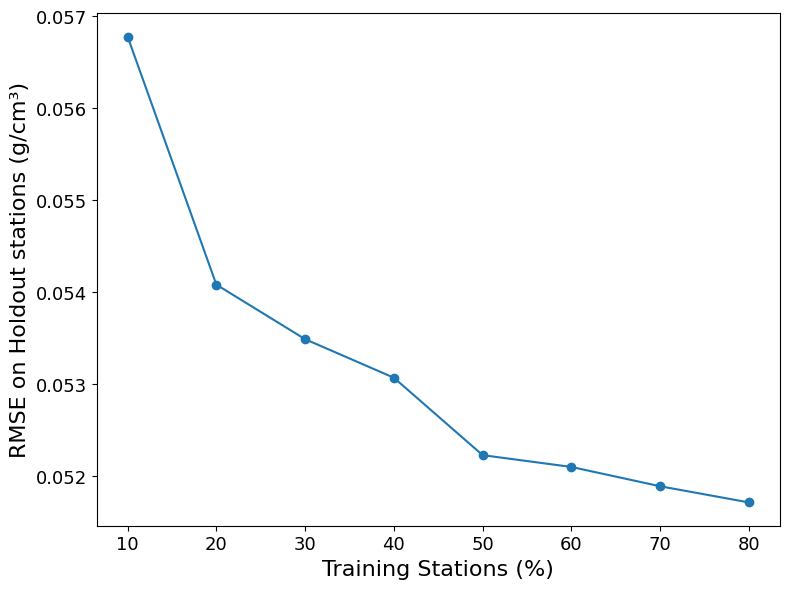

In [93]:
plt.figure(figsize=(8, 6))
plt.plot([r['training_percent'] for r in results], [r['rmse'] for r in results], 'o-')
plt.xlabel('Training Stations (%)', fontsize=16)
plt.ylabel('RMSE on Holdout stations (g/cm³)', fontsize=16)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.tight_layout()
plt.savefig('../plots/figure11.jpg', dpi=300, bbox_inches='tight')
plt.show()

## Retrain with 10\% data

In [103]:
retrain_stations, test_stations = train_test_split(
    unique_stations, 
    test_size=0.1, 
    random_state= 42,#all_config.global_cfg.seed, 100, 1000
    shuffle=True
)

# Get data for each set of stations
retrain_data = clean_df[clean_df['SITE_NAME'].isin(retrain_stations)]
test_data = clean_df[clean_df['SITE_NAME'].isin(test_stations)]

# Prepare test set (we'll use same test set for all experiments)
feature_cols = ['Elevation', 'Snow_Depth', 'DOWY', 'Latitude', 'Longitude', 'Snow_Class']
X_test = test_data[feature_cols].copy()
y_test = test_data['Snow_Density']

train_subset = clean_df[clean_df['SITE_NAME'].isin(retrain_stations)]
    
# Prepare features and target
X_train_subset = train_subset[feature_cols].copy()
y_train_subset = train_subset['Snow_Density']

print(f"Test set: {len(test_stations)} stations, {len(y_test)} data points")
print(f"Train set: {len(retrain_stations)} stations, {len(y_train_subset)} data points")

Test set: 35 stations, 2410 data points
Train set: 309 stations, 19137 data points


In [104]:
snow_class_encoder = TargetEncoder(
    target_type = 'continuous', cv=5,
    random_state = all_config.global_cfg.seed, smooth = 'auto'
)

X_train_subset['Snow_Class'] = snow_class_encoder.fit_transform(
    X_train_subset[['Snow_Class']], y_train_subset
)

# Encode Snow_Class for test data using fitted encoder
X_test_encoded = X_test.copy()
X_test_encoded['Snow_Class'] = snow_class_encoder.transform(X_test[['Snow_Class']])

# Retrain model
train_data = lgb.Dataset(X_train_subset, label=y_train_subset)

retrained_model = lgb.train(
    params_from_optuna,
    train_data,
    num_boost_round=raw_config['performance']['metrics']['best_iteration']
)

# Test on holdout
y_pred = retrained_model.predict(X_test_encoded)
rmse = root_mean_squared_error(y_true=y_test, y_pred=y_pred)

In [ ]:
float(y_train_subset.mean())

np.float64(0.2797026164407758)

In [105]:
density_results2=(
    clean_df.iloc[X_test.index]
    .assign(
        Observed_Density=y_test.values,
        Jonas_Density=lambda x: x.loc[:, ('Snow_Depth', 'Date', 'Elevation')].apply(lambda y: JonasDensity().compute_density(snow_depth=y.Snow_Depth*0.01, month=y.Date.month_name(), elevation= y.Elevation), axis=1),
        Pistochi_Density=lambda x: x.loc[:, 'Pistochi_DOWY'].apply(lambda y: PistochiDensity().compute_density(DOY=y)),
        Sturm_Density=lambda x: x.loc[:, ('Snow_Depth', 'Sturm_DOWY', 'Snow_Class')].apply(lambda y: SturmDensity().compute_density(snow_depth=y.Snow_Depth, DOY=y.Sturm_DOWY, snow_class= y.Snow_Class), axis=1),
        LightGBM_Density=y_pred,
        Baseline = float(y_train_subset.mean())
    )
    .filter(items=['Observed_Density', 'Jonas_Density', 'Pistochi_Density', 'Sturm_Density', 'LightGBM_Density', 'Baseline', 'SWE', 'Snow_Depth', 'Snow_Class'])
    .reset_index(drop=True)
)

density_results2.head()

,Observed_Density,Jonas_Density,Pistochi_Density,Sturm_Density,LightGBM_Density,Baseline,SWE,Snow_Depth,Snow_Class
0,0.291667,0.335377,0.412,0.356059,0.276515,0.279703,23.1140,79.248,Alpine
1,0.280000,0.362875,0.413,0.352387,0.296739,0.279703,17.7800,63.500,Alpine
2,0.193919,0.335256,0.396,0.339670,0.237442,0.279703,14.5796,75.184,Alpine
3,0.461538,0.333991,0.397,0.327318,0.315488,0.279703,15.2400,33.020,Alpine
4,0.236000,0.334905,0.397,0.337021,0.268866,0.279703,14.9860,63.500,Alpine


In [106]:
swe_results2=(
    density_results2
    .assign(
        Observed_SWE=density_results2.SWE.values,
        Jonas_SWE=lambda x: x.Jonas_Density.values * x.Snow_Depth.values,
        Sturm_SWE=lambda x: x.Sturm_Density.values * x.Snow_Depth.values,
        Pistochi_SWE=lambda x: x.Pistochi_Density.values * x.Snow_Depth.values,
        XGBoost_SWE=lambda x: x.LightGBM_Density.values * x.Snow_Depth.values,
        Baseline_SWE = lambda x: x.Baseline.values * x.Snow_Depth.values
    )
    .drop(
        columns=[
            'Observed_Density', 
            'Jonas_Density', 
            'Pistochi_Density', 
            'Sturm_Density', 
            'Snow_Depth',
            'LightGBM_Density',
            'Baseline',
            'SWE'
        ]
    )
)

swe_results2.head()

,Snow_Class,Observed_SWE,Jonas_SWE,Sturm_SWE,Pistochi_SWE,XGBoost_SWE,Baseline_SWE
0,Alpine,23.1140,26.577991,28.216999,32.650176,21.913274,22.165873
1,Alpine,17.7800,23.042562,22.376550,26.225500,18.842950,17.761116
2,Alpine,14.5796,25.205851,25.537756,29.772864,17.851828,21.029162
3,Alpine,15.2400,11.028370,10.808031,13.108940,10.417408,9.235780
4,Alpine,14.9860,21.266467,21.400856,25.209500,17.072992,17.761116


In [107]:
compare_multiple_models(preds_df=density_results2.dropna().drop(columns=['Snow_Class', 'SWE', 'Snow_Depth']), y_true='Observed_Density')

,Jonas_Density,Pistochi_Density,Sturm_Density,LightGBM_Density,Baseline
RMSE,0.075038,0.125640,0.077665,0.051717,0.070372
MBE,0.039377,0.109484,0.042840,0.000490,-0.000129
RSQ,-0.137003,-2.187557,-0.218027,0.459903,-0.000003


In [108]:
compare_multiple_models(preds_df=swe_results2.dropna().drop(columns='Snow_Class'), y_true='Observed_SWE')

,Jonas_SWE,Sturm_SWE,Pistochi_SWE,XGBoost_SWE,Baseline_SWE
RMSE,4.397472,4.649641,7.297953,2.348988,3.261821
MBE,2.487939,2.731159,5.736819,0.043297,0.463078
RSQ,0.474658,0.412681,-0.446897,0.850102,0.710961


## What if we retrained with 80\%?

In [82]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    x_test_maine, clean_df.Snow_Density, test_size=0.2, random_state=all_config.global_cfg.seed, stratify=clean_df.Snow_Class
)

# train the lgbm model model

train_data = lgb.Dataset(X_train, label=y_train)

lgbm_main = lgb.train(
    params_from_optuna,
    train_data,
    num_boost_round=raw_config['performance']['metrics']['best_iteration'] # best iteration from Optuna
)

predictions_lgb = lgbm_main.predict(X_test)

In [83]:
density_results2=(
    clean_df.iloc[X_test.index]
    .assign(
        Observed_Density=y_test.values,
        Jonas_Density=lambda x: x.loc[:, ('Snow_Depth', 'Date', 'Elevation')].apply(lambda y: JonasDensity().compute_density(snow_depth=y.Snow_Depth*0.01, month=y.Date.month_name(), elevation= y.Elevation), axis=1),
        Pistochi_Density=lambda x: x.loc[:, 'Pistochi_DOWY'].apply(lambda y: PistochiDensity().compute_density(DOY=y)),
        Sturm_Density=lambda x: x.loc[:, ('Snow_Depth', 'Sturm_DOWY', 'Snow_Class')].apply(lambda y: SturmDensity().compute_density(snow_depth=y.Snow_Depth, DOY=y.Sturm_DOWY, snow_class= y.Snow_Class), axis=1),
        LightGBM_Density=predictions_lgb
    )
    .filter(items=['Observed_Density', 'Jonas_Density', 'Pistochi_Density', 'Sturm_Density', 'LightGBM_Density', 'SWE', 'Snow_Depth', 'Snow_Class'])
    .reset_index(drop=True)
)

density_results2.head()

,Observed_Density,Jonas_Density,Pistochi_Density,Sturm_Density,LightGBM_Density,SWE,Snow_Depth,Snow_Class
0,0.315789,0.335172,0.402,0.343239,0.302983,22.8600,72.390,Prairie
1,0.310680,0.281355,0.366,0.291028,0.268258,8.1280,26.162,Alpine
2,0.269048,0.336200,0.395,0.348288,0.269072,28.7020,106.680,Alpine
3,0.249451,0.283161,0.368,0.300585,0.249629,11.5316,46.228,Alpine
4,0.268421,0.334448,0.405,0.340157,0.300244,12.9540,48.260,Alpine


In [85]:
swe_results2=(
    density_results2
    .assign(
        Observed_SWE=density_results2.SWE.values,
        Jonas_SWE=lambda x: x.Jonas_Density.values * x.Snow_Depth.values,
        Sturm_SWE=lambda x: x.Sturm_Density.values * x.Snow_Depth.values,
        Pistochi_SWE=lambda x: x.Pistochi_Density.values * x.Snow_Depth.values,
        XGBoost_SWE=lambda x: x.LightGBM_Density.values * x.Snow_Depth.values
    )
    .drop(
        columns=[
            'Observed_Density', 
            'Jonas_Density', 
            'Pistochi_Density', 
            'Sturm_Density', 
            'Snow_Depth',
            'LightGBM_Density',
            'SWE'
        ]
    )
)

swe_results2.head()

,Snow_Class,Observed_SWE,Jonas_SWE,Sturm_SWE,Pistochi_SWE,XGBoost_SWE
0,Prairie,22.8600,24.263079,24.847080,29.100780,21.932944
1,Alpine,8.1280,7.360799,7.613874,9.575292,7.018161
2,Alpine,28.7020,35.865859,37.155338,42.138600,28.704558
3,Alpine,11.5316,13.089945,13.895424,17.011904,11.539850
4,Alpine,12.9540,16.140451,16.415988,19.545300,14.489786


In [86]:
compare_multiple_models(preds_df=density_results2.dropna().drop(columns=['Snow_Class', 'SWE', 'Snow_Depth']), y_true='Observed_Density')

,Jonas_Density,Pistochi_Density,Sturm_Density,LightGBM_Density
RMSE,0.075522,0.125717,0.078325,0.050346
MBE,0.040169,0.109866,0.043951,-0.000446
RSQ,-0.177836,-2.263819,-0.266882,0.476550


In [87]:
compare_multiple_models(preds_df=swe_results2.dropna().drop(columns='Snow_Class'), y_true='Observed_SWE')

,Jonas_SWE,Sturm_SWE,Pistochi_SWE,XGBoost_SWE
RMSE,4.705170,4.974422,7.775856,2.467825
MBE,2.721723,2.999478,6.129250,0.001392
RSQ,0.491630,0.431783,-0.388436,0.860151


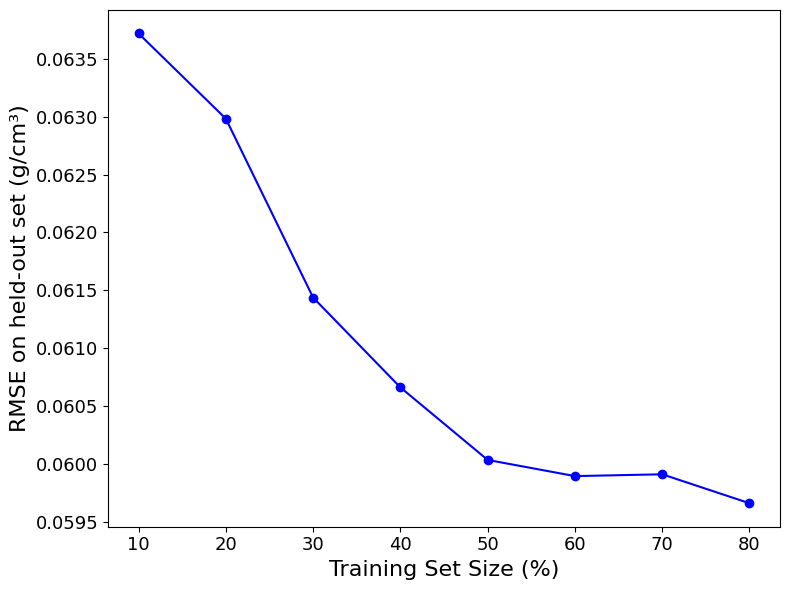

In [14]:
# Optimal Hyperparameters from model training
xgb_params_from_optuna={
    'objective': 'reg:squarederror',
    'random_state': 42,
    'learning_rate': 0.012571635462866944,
    'gamma': 1.8331574770840668e-06,
    'min_child_weight': 12.338531236617445,
    'max_bin': 3350,
    'max_depth': 17,
    'subsample': 1,
    'device': xgb_device,  
    'tree_method': 'hist',
    'sampling_method': 'gradient_based'
}


sizes_percent, rmse_values = plot_learning_curve(
    X_test_main, clean_df.Snow_Density, xgb_params=xgb_params_from_optuna
)


plt.figure(figsize=(8, 6))
plt.plot(sizes_percent, rmse_values, 'o-', color='blue')
plt.xlabel('Training Set Size (%)', fontsize=16)
plt.ylabel('RMSE on held-out set (g/cm³)', fontsize=16)
plt.yticks(fontsize=13)
plt.xticks(sizes_percent, fontsize=13)
plt.tight_layout()
plt.savefig('../plots/figure11.jpg', dpi=300, bbox_inches='tight')
plt.show()

### Train with 10% Local Data 

In [27]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_test_main, clean_df.Snow_Density, test_size=0.9, random_state=42, stratify=clean_df.Snow_Class
)

# train the xgboost model
train_data_full = xgb.DMatrix(X_train, label=y_train)
xgb_model = xgb.train(xgb_params_from_optuna, train_data_full, num_boost_round=1498) 
predictions_XGB = xgb_model.predict(xgb.DMatrix(X_test))

In [28]:
density_results2=(
    clean_df.iloc[X_test.index]
    .assign(
        Observed_Density=y_test,
        Jonas_Density=lambda x: x.loc[:, ('Snow_Depth', 'Date', 'Elevation')].apply(lambda y: JonasDensity().compute_density(snow_depth=y.Snow_Depth*0.01, month=y.Date.month_name(), elevation= y.Elevation), axis=1),
        Pistochi_Density=lambda x: x.loc[:, 'Pistochi_DOWY'].apply(lambda y: PistochiDensity().compute_density(DOY=y)),
        Sturm_Density=lambda x: x.loc[:, ('Snow_Depth', 'Sturm_DOWY', 'Snow_Class')].apply(lambda y: SturmDensity().compute_density(snow_depth=y.Snow_Depth, DOY=y.Sturm_DOWY, snow_class= y.Snow_Class), axis=1),
        XGBoost_Density=predictions_XGB
    )
    .filter(items=['Observed_Density', 'Jonas_Density', 'Pistochi_Density', 'Sturm_Density', 'XGBoost_Density', 'SWE', 'Snow_Depth', 'Snow_Class'])
    .reset_index(drop=True)
)

density_results2.head()

,Observed_Density,Jonas_Density,Pistochi_Density,Sturm_Density,XGBoost_Density,SWE,Snow_Depth,Snow_Class
0,0.282609,0.334402,0.383,0.317206,0.255856,13.208,46.736,Alpine
1,0.304598,0.334326,0.389,0.322688,0.269420,13.462,44.196,Alpine
2,0.452941,0.282886,0.355,0.284406,0.187163,19.558,43.180,Alpine
3,0.265363,0.335728,0.406,0.353930,0.286673,24.130,90.932,Alpine
4,0.336842,0.334448,0.394,0.329172,0.295974,16.256,48.260,Alpine


In [29]:
swe_results2=(
    density_results2
    .assign(
        Observed_SWE=density_results2.SWE,
        Jonas_SWE=lambda x: x.Jonas_Density * x.Snow_Depth,
        Sturm_SWE=lambda x: x.Sturm_Density * x.Snow_Depth,
        Pistochi_SWE=lambda x: x.Pistochi_Density * x.Snow_Depth,
        XGBoost_SWE=lambda x: x.XGBoost_Density * x.Snow_Depth
    )
    .drop(
        columns=[
            'Observed_Density', 
            'Jonas_Density', 
            'Pistochi_Density', 
            'Sturm_Density', 
            'Snow_Depth',
            'XGBoost_Density',
            'SWE'
        ]
    )
)

swe_results2.head()

,Snow_Class,Observed_SWE,Jonas_SWE,Sturm_SWE,Pistochi_SWE,XGBoost_SWE
0,Alpine,13.208,15.628616,14.824957,17.899888,11.957668
1,Alpine,13.462,14.775867,14.261537,17.192244,11.907273
2,Alpine,19.558,12.215026,12.280632,15.328900,8.081715
3,Alpine,24.130,30.528415,32.183604,36.918392,26.067758
4,Alpine,16.256,16.140451,15.885856,19.014440,14.283707


In [30]:
compare_multiple_models(preds_df=swe_results2.dropna().drop(columns='Snow_Class'), y_true='Observed_SWE')

,Jonas_SWE,Sturm_SWE,Pistochi_SWE,XGBoost_SWE
RMSE,4.486743,4.776157,7.413676,2.766413
MBE,2.478377,2.734780,5.598891,-0.083550
RSQ,0.626328,0.576567,-0.020223,0.857943


## The End!